## Import Packages

In [2]:
# import packages 
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image   import ImageDataGenerator
from tensorflow.keras.preprocessing.image   import load_img, img_to_array
from tensorflow.keras.models                import load_model
from tensorflow       import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image

### Use `ResNet` as a pre-trained model

In [17]:
# create ResNet50 model with pre-trained weights
base_model = ResNet50(weights='imagenet', include_top=False)

# freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

In [30]:
# add classification layers on top of the base model
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
predictions = tf.keras.layers.Dense(2, activation='softmax')(x)

# create new model
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

In [31]:
# define data generators for train and validation sets
data_gen = ImageDataGenerator(rescale=1./255)

train_generator = data_gen.flow_from_directory(
        '.\Face Mask Dataset\Train',
        batch_size=8,
        class_mode='categorical')

val_generator = data_gen.flow_from_directory(
        '.\Face Mask Dataset\Validation',
        batch_size=8,
        class_mode='categorical')

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [32]:
# train the model
history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=10,
        validation_data=val_generator,
        validation_steps=val_generator.samples//val_generator.batch_size,
        verbose = 1)

# save the trained model
model.save('resnet.h5')


Epoch 1/10
1250/1250 [==============================] - 541s 432ms/step - loss: 0.6316 - accuracy: 0.6193 - precision: 0.6193 - recall: 0.6193 - val_loss: 0.5770 - val_accuracy: 0.6525 - val_precision: 0.6525 - val_recall: 0.6525
Epoch 2/10
1250/1250 [==============================] - 535s 428ms/step - loss: 0.4688 - accuracy: 0.7826 - precision: 0.7826 - recall: 0.7826 - val_loss: 0.4179 - val_accuracy: 0.7937 - val_precision: 0.7937 - val_recall: 0.7937
Epoch 3/10
1250/1250 [==============================] - 561s 449ms/step - loss: 0.3684 - accuracy: 0.8458 - precision: 0.8458 - recall: 0.8458 - val_loss: 0.2819 - val_accuracy: 0.8825 - val_precision: 0.8825 - val_recall: 0.8825
Epoch 4/10
1250/1250 [==============================] - 548s 438ms/step - loss: 0.3080 - accuracy: 0.8761 - precision: 0.8761 - recall: 0.8761 - val_loss: 0.2651 - val_accuracy: 0.8875 - val_precision: 0.8875 - val_recall: 0.8875
Epoch 5/10
1250/1250 [==============================] - 533s 427ms/step - loss: 

### Evaluate

In [33]:
def evaluate(test_path, model_path):

    # Load the saved model
    loaded_model = load_model(model_path)

    # Define the input shape of the images
    input_shape = (224, 224, 3)

    # Load the test data from a directory
    test_with_mask_images = os.listdir(os.path.join(test_path, "WithMask"))
    test_without_mask_images = os.listdir(os.path.join(test_path, "WithoutMask"))

    # predictions list
    with_mask_pred, without_mask_pred = [], []

    # Loop through the with mask images and make predictions
    for image_name in test_with_mask_images:

        # Load the image and convert it to a NumPy array
        image = load_img(os.path.join(test_path, "WithMask", image_name), target_size=input_shape[:2])
        image_array = img_to_array(image) / 255.0
        image_array = np.expand_dims(image_array, axis=0)
        
        # make prediction for the with mask images
        prediction = loaded_model.predict(image_array)
        predicted_class = np.argmax(prediction)

        # Print the predicted class
        if predicted_class == 0:
            with_mask_pred.append(1)
        else:
            with_mask_pred.append(0)

    # Loop through the without mask images and make predictions
    for image_name in test_without_mask_images:

        # Load the image and convert it to a NumPy array
        image = load_img(os.path.join(test_path, "WithoutMask", image_name), target_size=input_shape[:2])
        image_array = img_to_array(image) / 255.0
        image_array = np.expand_dims(image_array, axis=0)
        
        # make predictions for the without mask images
        prediction = loaded_model.predict(image_array)
        predicted_class = np.argmax(prediction)

        # Print the predicted class
        if predicted_class == 0:
            without_mask_pred.append(1)
        else:
            without_mask_pred.append(0)
    
    # initialize the tp, tn, fp, fn
    tp, tn, fp, fn = 0, 0, 0, 0

    # calculate tp, fn through the with mask images predicitons
    for i in with_mask_pred:
        if i == 1:
            tp += 1
        else:
            fn += 1

    # calculate tn, fp throught the without mask images predictions
    for i in without_mask_pred:
        if i == 0:
            tn += 1
        else:
            fp += 1

    # calculate the precision, recall, and f1-score by their equations
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * precision * recall / (precision + recall)
    accuracy = (tp + tn) / (tp + fp + tn + fn)

    # return the precision, recall, and f1-score
    return precision, recall, f1_score, accuracy


In [34]:
precision, recall, f1_score, accuracy = evaluate(".\\Face Mask Dataset\Test", 'resnet.h5')

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", f1_score)

1/1 [==============================] - 0s 94ms/step
Accuracy:  0.9112903225806451
Precision:  0.9379157427937915
Recall:  0.8757763975155279
F1-score:  0.9057815845824412


In [35]:
def show_pred(img_path, model_path):

    # Load the model
    loaded_model = load_model(model_path)

    # Load the image and resize it to the input size of the model
    img = image.load_img(img_path, target_size=(224,224))
    img_arr = image.img_to_array(img) / 255.0
    img_arr = np.expand_dims(img_arr, axis=0)

    # Make a prediction with the model
    prediction = loaded_model.predict(img_arr)

    # Get the predicted class label
    class_label = np.argmax(prediction)

    # make the predictions as string label
    pred = "With Mask" if class_label == 0 else "Without Mask"

    # Display the image with the predicted class label
    plt.imshow(img)
    plt.axis('off')
    plt.title('Prediction: {}'.format(pred))
    plt.show()

1/1 [==============================] - 1s 600ms/step


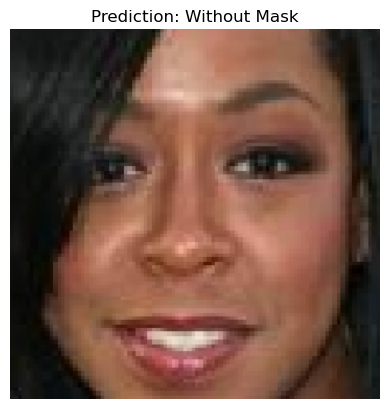

In [36]:
show_pred('.\\Face Mask Dataset\Test\WithoutMask\\47.png', 'resnet.h5')

1/1 [==============================] - 1s 594ms/step


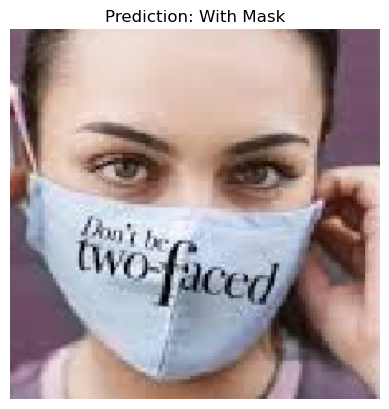

In [37]:
show_pred('.\\Face Mask Dataset\Test\WithMask\\608.png', 'resnet.h5')

### 2. Build model from scratch

In [83]:
# Define the input shape of the images
input_shape = (224, 224, 3)

# Define the model architecture
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(2, activation='softmax')
])

# Compile the model with binary cross-entropy loss and Adam optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 26, 26, 128)     

In [84]:
# Create an instance of the ImageDataGenerator class with data augmentation parameters
data_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Load the training and validation data from a directory
train_data = data_generator.flow_from_directory(
    '.\Face Mask Dataset\Train',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='training'
)

val_data = data_generator.flow_from_directory(
    '.\Face Mask Dataset\Validation',
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='validation'
)

Found 8000 images belonging to 2 classes.
Found 160 images belonging to 2 classes.


In [85]:
# Train the model
model.fit(train_data, epochs=10, validation_data=val_data)

Epoch 1/10
250/250 [==============================] - 229s 914ms/step - loss: 0.2378 - accuracy: 0.9062 - val_loss: 0.1532 - val_accuracy: 0.9312
Epoch 2/10
250/250 [==============================] - 190s 758ms/step - loss: 0.1834 - accuracy: 0.9376 - val_loss: 0.1718 - val_accuracy: 0.9312
Epoch 3/10
250/250 [==============================] - 195s 778ms/step - loss: 0.1597 - accuracy: 0.9419 - val_loss: 0.1397 - val_accuracy: 0.9438
Epoch 4/10
250/250 [==============================] - 193s 771ms/step - loss: 0.1404 - accuracy: 0.9501 - val_loss: 0.1379 - val_accuracy: 0.9688
Epoch 5/10
250/250 [==============================] - 184s 735ms/step - loss: 0.1369 - accuracy: 0.9535 - val_loss: 0.1491 - val_accuracy: 0.9563
Epoch 6/10
250/250 [==============================] - 186s 743ms/step - loss: 0.1289 - accuracy: 0.9554 - val_loss: 0.0708 - val_accuracy: 0.9625
Epoch 7/10
250/250 [==============================] - 184s 737ms/step - loss: 0.1282 - accuracy: 0.9570 - val_loss: 0.1053 -

In [86]:
model.save("tf_model.h5")

#### Evaluate 

In [39]:
precision, recall, f1_score, accuracy = evaluate(".\\Face Mask Dataset\Test", "tf_model.h5")

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("recall: ", recall)
print("F1-score: ", f1_score)

1/1 [==============================] - 0s 28ms/step
Accuracy:  0.9808467741935484
Precision:  0.977366255144033
recall:  0.9834368530020704
F1-score:  0.9803921568627451


1/1 [==============================] - 0s 77ms/step


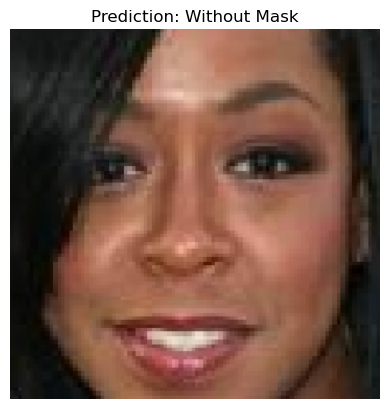

In [14]:
show_pred('.\\Face Mask Dataset\Test\WithoutMask\\47.png', 'tf_model.h5')

1/1 [==============================] - 0s 67ms/step


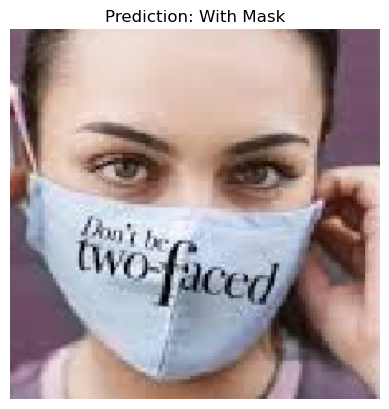

In [15]:
show_pred('.\\Face Mask Dataset\Test\WithMask\\608.png', 'tf_model.h5')

In [15]:
import onnx

In [18]:
loaded_model = load_model('tf_model.h5')
tf.saved_model.save(loaded_model, "tmp_model_tf")

INFO:tensorflow:Assets written to: tmp_model_tf\assets


INFO:tensorflow:Assets written to: tmp_model_tf\assets


In [17]:
loaded_model = load_model('resnet.h5')
tf.saved_model.save(loaded_model, "tmp_model_res")

INFO:tensorflow:Assets written to: tmp_model_res\assets


INFO:tensorflow:Assets written to: tmp_model_res\assets


Run the following command `python -m tf2onnx.convert --saved-model tmp_model --output "tf_model.onnx"`